# **Theoretical Model and Numerical Simulation of Liquity**


**Sequence of events**

> In each period, the following events occur sequentially


* exogenous ether price input
* trove liquidation 
* return of the previous period's stability pool determined (liquidation gain & airdropped LQTY gain)
* trove closure
* trove adjustment
* open trove 
* issuance fee
* trove pool formed
* LUSD supply determined
* LUSD stability pool demand determined
* LUSD liquidity pool demand determined
* LUSD price determined
* redemption & redemption fee
* LQTY pool return determined










**Global variables**

period = 24 *365 = 8760

initial ether price = 200

issuance fee =0.02

redemption fee = 0.01


In [ ]:
import random
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import scipy.stats
from plotly.subplots import make_subplots

#policy functions
rate_issuance = 0.01
rate_redemption = 0.01
base_rate_initial = 0

#global variables
period = 24*365
month=24*30
day=24

#ether price
price_ether_initial = 1000
price_ether = [price_ether_initial]
sd_ether=0.02
drift_ether = 0

#LQTY price & airdrop
price_LQTY_initial = 1
price_LQTY = [price_LQTY_initial]
sd_LQTY=0.005
drift_LQTY = 0.0035
#reduced for now. otherwise the initial return too high
quantity_LQTY_airdrop = 200
supply_LQTY=[0]
LQTY_total_supply=100000000

#PE ratio
PE_ratio = 50

#natural rate
natural_rate_initial = 0.2
natural_rate = [natural_rate_initial]
sd_natural_rate=0.002

#stability pool
initial_return=0.2
return_stability=[initial_return]
sd_return=0.001
sd_stability=0.001
drift_stability=1.002
theta=0.005

#liquidity pool & redemption pool
sd_liquidity=0.001
sd_redemption=0.001
drift_liquidity=1.0003
redemption_star = 0.8
delta = -20

#close troves
sd_closetroves=0.5
#sensitivity to LUSD price
beta = 0.2

#open troves
distribution_parameter1_ether_quantity=10
distribution_parameter2_ether_quantity=500
distribution_parameter1_CR = 1.1
distribution_parameter2_CR = 0.1
distribution_parameter3_CR = 16
distribution_parameter1_inattention = 4
distribution_parameter2_inattention = 0.08
sd_opentroves=0.5
n_steady=0.5
initial_open=10

#sensitivity to LUSD price & issuance fee
alpha = 0.3

#number of runs in simulation
n_sim= 8640

**Exogenous ether price**

Ether is the collateral for LUSD. The ether price $P_t^e$ follows 
> $P_t^e = P_{t-1}^e (1+\zeta_t^e)(1+\sigma_t^e)$, 

where $\zeta_t^e \sim N(0, 0.02)$ represents ether price shock and $\sigma_t^e=0$ the drift of ether price.

The price of Ether is visualized as follows.


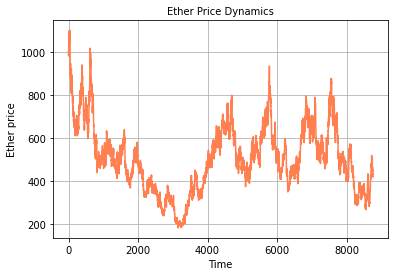

In [ ]:
price_ether = [price_ether_initial]
for i in range(1, period):
  random.seed(2019375+10000*i)
  shock_ether = random.normalvariate(0,0.02)
  drift_ether = 0
  price_ether.append(price_ether[i-1]*(1+shock_ether)*(1+drift_ether))

x = np.linspace(0, period, period)
y = price_ether
plt.plot(x, y, color='coral')
plt.grid()
plt.title('Ether Price Dynamics',fontsize=10)
plt.xlabel('Time')
plt.ylabel('Ether price')
plt.show()

**Trove pool**

Each trove is defined by five numbers
> (collateral in ether, debt in LUSD, collateral ratio target, rational inattention, collateral ratio)

which can be denoted by
> ($Q_t^e(i)$, $Q_t^d(i)$, $CR^*(i)$, $\tau(i)$, $CR_t(i)$).

---
The amount of new troves opened in period t is denoted by $N_t^o$, which follows $N_t^o=N^s(1+\zeta_t^o)$,
where $N^s$ represents the steady state number of troves opened and the shock $\zeta_t^o \sim N(0,0.01)$. more troves are opened when the LUSD price is hikes.
$N_t^o$ is rounded to an integer.

---
The amount of troves closed in period t is denoted as $N_t^c$.
$N_t^c=N^s(1+\zeta_t^c)$,

where closed in each period and the shock $\zeta_t^c \sim N(0,0.01)$.
When the LUSD price is lower than $\$1$, more troves are closed.  
$N_t^c$ is rounded to an integer.


**Trove Liquidation**

At the beginning of each period, 
right after the feed of ether price, 
the system checks the collateral ratio of the exisitng troves in the
trove pool. 

If the collateral ratio falls below 110%, i.e.
> $$CR_t(i) = \frac{P_t^e Q_t^e(i)}{Q_t^d(i)}<110\%,$$

this trove is liquidated. Namely, it is eliminated from the trove pool.

Denote the amount of liquidated troves by $N_t^l$. The sum of the debt amounts to
> $$Q_t^d=\sum_i^{N_t^l} Q_t^d(i)$$

The amount of ether is
> $$Q_t^e=\sum_i^{N_t^l} Q_t^e(i)$$

The debt $Q_t^d$ is paid by the stability pool in exchange for the collateral $Q_t^e$. Therefore, the return of the prvious period's stability pool is


> $$R_{t-1}^s=\frac{R_t^l+R_t^a}{P_{t-1}^lD_{t-1}^s}$$

where the liquidation gain $R_t^l=P_t^eQ_t^e-P_{t-1}^lQ_t^d$ and the airdrop gain $R_t^a=P_{t}^q\hat{Q}_t^q$.

$\hat{Q}_t^q$ denotes the amount of LQTY token airdropped to the stability pool providers. In the first month, the price of LQTY follows

> $P_t^q = P_{t-1}^q (1+\zeta_t^q)(1+\sigma_t^q)$. 

Note that $\zeta_t^q \sim N(0, 0.005)$ represents LQTY price shock and $\sigma_t^q = 0.0035$ the price drift.

The LQTY price from the second month on is endogenously determined and will be shown later. 

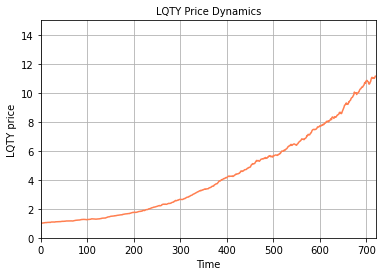

In [ ]:
#LQTY Price Dynamics in the first month
price_LQTY_initial = 1
first_month=24*30
price_LQTY = [price_LQTY_initial]

for i in range(1, first_month):
  random.seed(2+13*i)
  shock_LQTY = random.normalvariate(0,0.005)
  drift_LQTY = 0.0035
  price_LQTY.append(price_LQTY[i-1]*(1+shock_LQTY)*(1+drift_LQTY))

x = np.linspace(0, first_month, first_month)
y = price_LQTY
plt.plot(x, y, color='coral')
plt.grid()
plt.xlim(0, first_month)
plt.ylim(0, 15)
plt.title('LQTY Price Dynamics',fontsize=10)
plt.xlabel('Time')
plt.ylabel('LQTY price')
plt.show()

In [ ]:
def liquidate_troves(troves, index, price_LUSD_previous, stability_pool_previous):
  troves['CR_current'] = troves['Ether_Price']*troves['Ether_Quantity']/troves['Supply']

  troves_liquidated = troves[troves.CR_current < 1.1]
  troves = troves[troves.CR_current >= 1.1]
  debt_liquidated = troves_liquidated['Supply'].sum()
  ether_liquidated = troves_liquidated['Ether_Quantity'].sum()
  n_liquidate = troves_liquidated.shape[0]
  troves = troves.reset_index(drop = True)

  price_LQTY_current = price_LQTY[index-1]
  liquidation_gain = ether_liquidated*price_ether_current - debt_liquidated*price_LUSD_previous
  airdrop_gain = price_LQTY_current*quantity_LQTY_airdrop
  
  np.random.seed(2+index)
  shock_return = np.random.normal(0,sd_return)
  if index <= day:
   return_stability = initial_return*(1+shock_return)
  elif index<=month:
    #min function to rule out the large fluctuation caused by the large but temporary liquidation gain in a particular period
    return_stability = min(0.5, 365*(data.loc[index-day:index, 'liquidation_gain'].sum()+data.loc[index-day:index, 'airdrop_gain'].sum())/(price_LUSD_previous*stability_pool_previous))
   
  else:
    return_stability = (365/30)*(data.loc[index-month:index, 'liquidation_gain'].sum()+data.loc[index-month:index, 'airdrop_gain'].sum())/(price_LUSD_previous*stability_pool_previous)
  
  return[troves, return_stability, debt_liquidated, ether_liquidated, liquidation_gain, airdrop_gain, n_liquidate]

**Open Troves**


The amount of LUSD tokens generated by a new trove is
> $$Q_t^d(i) = \frac{P_t^e Q_t^e(i)}{CR^*(i)}.$$


---


The distribution of ether $Q_t^e(i)$ follows
> $Q_t^e(i) \sim \chi^2_{10}.$

So that $E(Q_t^e) = 10$ and $Var(Q_t^e) = 20$. 


---


$CR^*(i)$ follows a chi-squared distribution with $df=5$, i.e. $CR^*(i) \sim \chi_5^2$, so that $CR^*(i)\geq 110\%$. 
> $CR^*(i) = 1.1+0.38\chi_5^2$. 

Then $E(CR^*(i))=220\%, SD(CR^*(i))=120\%.$



---
Each trove is associated with a rational inattention parameter $\tau(i)$.

The collateral ratio of the existing troves vary with the ether price $P_t^e$
> $$CR_t(i) = \frac{P_t^e Q_t^e(i)}{Q_t^d(i)}.$$

If the collateral ratio falls in the range 
> $CR_t(i) \in [CR^*(i)(1-\tau(i)), CR^*(i)(1+2\tau(i))]$,

no action taken. Otherwise, the trove owner readjusts the collateral ratio so that
>  $CR_t(i)=CR^*(i)$.

The distribution of $\tau(i)$ follows gamma distribution $Gamma(k=25,\theta=0.02)$ with mean of 0.5 and standard error of  0.1.

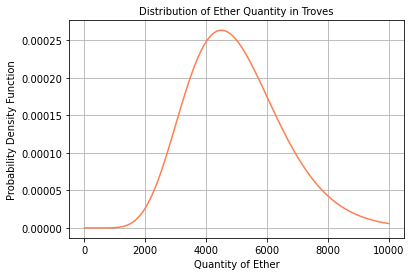

In [ ]:
x = np.linspace(0, 10000, 100)
#y = scipy.stats.chi2.pdf(x,400)
y = scipy.stats.gamma.pdf(x, a=10, scale=500)
plt.plot(x,y, color='coral')
plt.grid()
plt.title('Distribution of Ether Quantity in Troves',fontsize=10)
plt.xlabel('Quantity of Ether')
plt.ylabel('Probability Density Function')
plt.show()

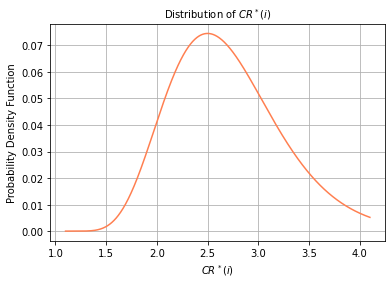

In [ ]:
t = np.linspace(0, 30, 1000)
x = 1.1+0.1*t
y = scipy.stats.chi2.pdf(t,16)
plt.plot(x,y, color='coral')
plt.grid()
plt.title('Distribution of $CR^*(i)$',fontsize=10)
plt.xlabel('$CR^*(i)$')
plt.ylabel('Probability Density Function')
plt.show()

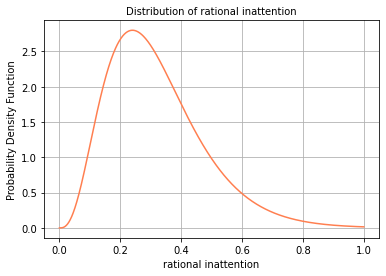

In [ ]:
x = np.linspace(0, 1, 1000)
y = scipy.stats.gamma.pdf(x, a=4, scale=0.08)
plt.plot(x,y, color='coral')
plt.grid()
plt.title('Distribution of rational inattention',fontsize=10)
plt.xlabel('rational inattention')
plt.ylabel('Probability Density Function')
plt.show()

In [ ]:
def open_troves(troves, index1, price_LUSD_previous):
  random.seed(2019*index1)  
  issuance_LUSD_open = 0
  shock_opentroves = random.normalvariate(0,sd_opentroves)
  n_troves = troves.shape[0]

  if index1<=0:
    number_opentroves = initial_open
  elif price_LUSD_previous <=1 + rate_issuance:
    number_opentroves = max(0, n_steady * (1+shock_opentroves))
  else:
    number_opentroves = max(0, n_steady * (1+shock_opentroves)) + alpha*(price_LUSD_previous-rate_issuance-1)*n_troves
  
  number_opentroves = int(round(float(number_opentroves)))

  for i in range(0, number_opentroves):
    price_ether_current = price_ether[index1]
    
    np.random.seed(2033 + index1 + i*i)
    CR_ratio = distribution_parameter1_CR + distribution_parameter2_CR * np.random.chisquare(df=distribution_parameter3_CR)
    
    np.random.seed(20 + 10 * i + index1)
    quantity_ether = np.random.gamma(distribution_parameter1_ether_quantity, scale=distribution_parameter2_ether_quantity)
    
    np.random.seed(209870- index1 + i*i)
    rational_inattention = np.random.gamma(distribution_parameter1_inattention, scale=distribution_parameter2_inattention)
    
    supply_trove = price_ether_current * quantity_ether / CR_ratio
    issuance_LUSD_open = issuance_LUSD_open + rate_issuance * supply_trove

    new_row = {"Ether_Price": price_ether_current, "Ether_Quantity": quantity_ether, 
               "CR_initial": CR_ratio, "Supply": supply_trove, 
               "Rational_inattention": rational_inattention, "CR_current": CR_ratio}
    troves = troves.append(new_row, ignore_index=True)

  return[troves, number_opentroves, issuance_LUSD_open]

**Close Troves**

---
At each time period, $N_t^c$ number of troves are closed, where $N_t^c$ has been defined above. The following code randomly picks $N_t^c$ number of troves among the existing troves and closes them.

In [ ]:
def close_troves(troves, index2, price_LUSD_previous):
  np.random.seed(208+index2)
  shock_closetroves = np.random.normal(0,sd_closetroves)
  n_troves = troves.shape[0]

  if index2 <= 240:
    number_closetroves = np.random.uniform(0,1)
  elif price_LUSD_previous >=1:
    number_closetroves = max(0, n_steady * (1+shock_closetroves))
  else:
    number_closetroves = max(0, n_steady * (1+shock_closetroves)) + beta*(1-price_LUSD_previous)*n_troves
  
  number_closetroves = int(round(number_closetroves))
  
  random.seed(293+100*index2)
  drops = list(random.sample(range(len(troves)), number_closetroves))
  troves = troves.drop(drops)
  troves = troves.reset_index(drop=True)
  if len(troves) < number_closetroves:
    number_closetroves = -999

  return[troves, number_closetroves]

**Trove Adjustment**

For simplicity, we assume trove owners always adjust trove collateral ratio by paying back debt. Trove owners could of course also top up the collateral.
The former is more challenging and more common. It happend to DAI: 
when ether price crashes, the demand for DAI skyrockets.
If the system could survive under this tough assumption, it for sure withstands the latter.

When the exogenous price of Ether varies, trove owners might want to adjust their troves to maintain a sustainable collateral ratio. Specifically, trove owners will not adjust the trove when 
> $$CR_t(i) \in [CR^*(i)-\tau(i), CR^*(i)+2\tau(i)],$$ 

Otherwise, the trove owners will either adjust the collateral or the debt so that the $CR_t(i)$ reverts back to $CR^*(i)$.

Denote the total number of adjusted troves by $N_t^a$ and the number of those that adjust debt by $\hat{N}_t^a$. Therefore, $0\leq \hat{N}_t^a\leq N_t^a$.

For $i\in \hat{N}_t^a$
> $$\hat{Q}_t^d(i)=\frac{P_t^e Q_{t-1}^e(i)}{CR^*(i)}. $$

For $i\in N_t^a-\hat{N}_t^a$
> $$\hat{Q}_t^e(i)=\frac{CR^*(i) Q_{t-1}^d(i)}{P_t^e}. $$

In [ ]:
def adjust_troves(troves, index):
  issuance_LUSD_adjust = 0
  random.seed(57984-3*index)
  ratio = random.uniform(0,1)
  for i in range(0, troves.shape[0]):
    random.seed(187*index + 3*i)
    working_trove = troves.iloc[i,:]
    p = random.uniform(0,1)
    check = (working_trove['CR_current']-working_trove['CR_initial'])/(working_trove['CR_initial']*working_trove['Rational_inattention'])

  #A part of the troves are adjusted by adjusting debt
    if p >= ratio:
      if check<-1:
        working_trove['Supply'] = working_trove['Ether_Price']*working_trove['Ether_Quantity']/working_trove['CR_initial']
      if check>2:
        supply_new = working_trove['Ether_Price']*working_trove['Ether_Quantity']/working_trove['CR_initial']
        issuance_LUSD_adjust = issuance_LUSD_adjust + rate_issuance * (supply_new - working_trove['Supply'])
        working_trove['Supply'] = supply_new
  #Another part of the troves are adjusted by adjusting collaterals
    if p < ratio and (check < -1 or check > 2):
      working_trove['Ether_Quantity'] = working_trove['CR_initial']*working_trove['Supply']/working_trove['Ether_Price']
    
    troves.loc[i] = working_trove
  return[troves, issuance_LUSD_adjust]

**Issuance Fee**

Troves need to pay issuance fee for issuing debt. For the moment, we assume a constant issuance fee


> $$f_t^i=1\%$$

The issunace fee revenue consists of two parts 
> $$R_t^i=P_t^lf_t^i (\sum_i^{N_t^o} Q_t^d(i) + \sum_i^{\hat{N}_t^{a+}} (\frac{P_t^e Q_t^e(i)}{CR^*(i)}-Q_{t-1}^d(i)))$$

where $\hat{N}_t^{a+}$ denotes the amount of adjusted troves that issue more debt.

Note that for the readjusted troves that issue more new LUSD, they only 
pay issuance fee of the newly minted debt, as the old debt was already
 charged.

The issuance fee flows first to the LQTY token holders but eventually to the 
LUSD market as well. 

**Liquidity Pool**

---
The demand of tokens from liquidity pool is defined by
> $$D_t^l = D_{t-1}^l (1+\zeta_t^l) (\frac{P_t^l}{P_{t-1}^l})^\delta, D_0^l = 0.5S_0$$

where $\zeta_t^l \sim N(0, 0.01)$ is the shock in the liquidity pool and $\delta \leq -1$.

**Stability Pool**

---
The demand of tokens from stability pool is defined by 
>$$D_t^s = D_{t-1}^s (1+\zeta_t^s) (1+R_{t-1}^s-R_{t}^n)^\theta, D_0^s = 0.5S_0$$

where $\zeta_t^s \sim N(0, 0.01)$ is the shock in the liquidity pool and $\theta > 0$. $R_{t-1}^s$ is the return in the stability pool, which consists of liquidation gain and airdrop LQTY gain.


The natural rate of the stability pool follows
> $$R_{t}^n=R_{t-1}^n(1+\zeta_t^n)\geq 0,$$

where $\zeta_t^n \sim N(0, 0.002)$ is the natural rate shock and $R_{0}^n=20\%$.

The natural rate compensates the opportunity cost and risk undertaken by the stability pool providers. It resembles the risk-free government bond return in the macroeconomics model. Stability pool depositors compare the return of the stability pool with the outside investment opportunities. A positive shock $\zeta_t^n$ implies investment on other platforms, e.g. Compound, Uniswap, Aave, yield higher returns, thus making the stability pool less appealing.


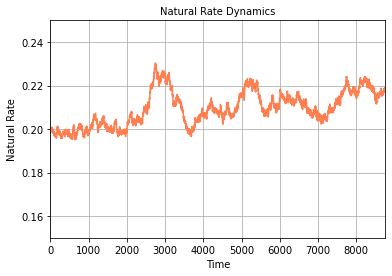

In [ ]:
natural_rate_initial = 0.2
natural_rate = [natural_rate_initial]
for i in range(1, period):
  random.seed(201597+10*i)
  shock_natural = random.normalvariate(0,0.002)
  natural_rate.append(natural_rate[i-1]*(1+shock_natural))

x = np.linspace(0, period, period)
y = natural_rate
plt.plot(x, y, color='coral')
plt.grid()
plt.xlim(0, period)
plt.ylim(0.15, 0.25)
plt.title('Natural Rate Dynamics',fontsize=10)
plt.xlabel('Time')
plt.ylabel('Natural Rate')
plt.show()

In [ ]:
def stability_update(stability_pool_previous, return_previous, index):
  np.random.seed(275+3*index)
  shock_stability = np.random.normal(0,0.01)
  natural_rate_current = natural_rate[index]
  stability_pool = stability_pool_previous* (1+shock_stability)* (1+ return_previous- natural_rate_current)**theta
  return[stability_pool]

**Price Determination**

---
With the supply and demand of LUSD tokens defined above, the price of LUSD at the current period is given by the following equilibrium condition:
> $$S_t = D_t^s + D_t^l = D_t^s + D_{t-1}^l (1+\zeta_t^l) (\frac{P_t^l}{P_{t-1}^l})^\delta$$

Solving this equation gives that:
> $$P_t^l = P_{t-1}^l(\frac{S_t-D_t^s}{D_{t-1}^l(1+\zeta_t^l)})^{1/\delta}$$

**Stabilizers**

There are two stabilizers to attenuate LUSD price deviation from its target range.
No action if $P_t^l \in [1-f_t^r, 1.1+f_t^i]$, where $f_t^r$ represents the redemption fee. 
For the moment, we set $f_t^r = 1\%$.


---
Stabilizer 1: ceiling arbitrageurs

If $P_t^l > 1.1+f_t^i$, open a new trove with $CR^*=110\%$ and $\tau^*=10\%$. Its debt amounts to 
> $$Q_t^d(c) = \frac{P_t^e Q_t^e(c)}{110\%}.$$

The amount of $Q_t^d(c)$ is expected to bring the LUSD price back to $1.1+f_t^i$. This means that 
> $$S_t' = D_t^s + (\frac{1.1+f_t^i}{P_{t-1}^l})^\delta D_{t-1}^l(1+\zeta_t^l)$$

The debt of th new trove is the difference between the original supply and the supply needed to bring price to $1.1+f_t^i$, which is 
> $$Q_t^d(c) = S_t' - S_t$$

**Programming logic**: 

market clearing condition supply = demand ==> $P_t^l$ is determined

If $P_t^l > 1.1+f_t^i$ ==> calculate what amount of extra supply leads to 
$P_t^l = 1.1+f_t^i$ ==> denote this amount by $Q_t^d(c)$ ==> open a trove
with $CR^*=110\%$ and debt = $Q_t^d(c)$

---
Stabilizer 2: floor arbitrageurs

If $P_t^l < 1-f_t^r$, a fraction $\chi_t$ of LUSD in the liquidity pool is used for redemption
> $$D_t^r = \chi_t D_t^l,$$

where 
> $$\chi_t = \chi^* (1+\xi_t^\chi)(1-f_t^r-P_t^l).$$

$\chi^*=1$ and $\xi_t^\chi$ follows ND(0, 0.01).

The redemption eliminates troves with the lowest collateral ratio.

Note that unlike stabilizer 1, stabilizer 2 has impact of LUSD price in
 the next period. Namely, after the determination of $P_t^l$ and if $P_t^l < 1-f_t^r$, the redemption does not affect $P_t^l$ any more. So no need to 
program stabilizer 2 like what you did for stabilizer 1. The redemption kills some troves and thus affect $P_{t+1}^l$ in the next period as the number of troves shrinks.  

**Programming logic**

Denote the amount of troves fully redeemed by $N_t^r$. Therefore, 
> $$D_t^r = \sum_i^{N_t^r} Q_t^d(i) + \Delta$$

where $\Delta \geq 0$ represents the residual. 

Note that the redemption starts from the riskest troves, i.e. those with
the lowest collateral ratios.

If any residual $\Delta > 0$ left, then the changes to the trove $j$ with the lowest collateral ratio are
> $$Q_{t+1}^e(j) = Q_{t}^e(j) - \Delta/P_t^e$$
> $$Q_{t+1}^d(j) = Q_{t}^d(j) - \Delta$$
> $$CR_{t+1}(j) = \frac{P_t^e(Q_{t}^e(j) - \Delta)}{Q_{t}^d(j) - \Delta}$$
---


Redemption fee revenue amounts to


> $$R_t^r = f_t^r\frac{D_t^r}{P_t^e}P_t^e=f_t^rD_t^r.$$



In [ ]:
def price_stabilizer(troves, index, data, stability_pool):
  issuance_LUSD_stabilizer = 0
  redemption_fee = 0
  n_redempt = 0
  redemption_pool = 0
  price_ether_current = price_ether[index]
#Calculating Price
  supply = sum(troves['Supply'])
  np.random.seed(20*index)
  shock_liquidity = np.random.normal(0,0.01)
  liquidity_pool_previous = float(data['liquidity'][index-1])
  price_LUSD_previous = float(data['Price_LUSD'][index-1])
  inflation = ((supply-stability_pool)/(liquidity_pool_previous*(1+shock_liquidity)))**(1/delta)
  price_LUSD_current= price_LUSD_previous * inflation

#Liquidity Pool
  liquidity_pool = liquidity_pool_previous * (1+shock_liquidity) * (price_LUSD_current/price_LUSD_previous)**delta

#Stabilizer
  #Ceiling Arbitrageurs
  if price_LUSD_current > 1.1 + rate_issuance:
    supply_current = sum(troves['Supply'])
    supply_wanted=stability_pool+liquidity_pool_previous*(1+shock_liquidity)*((1.1+rate_issuance)/price_LUSD_previous)**delta
    supply_trove = supply_wanted - supply_current

    price_ether_current = price_ether[index]
    CR_ratio = 1.1
    rational_inattention = 0.1
    quantity_ether = supply_trove * CR_ratio / price_ether_current
    issuance_LUSD_stabilizer = rate_issuance * supply_trove

    new_row = {"Ether_Price": price_ether_current, "Ether_Quantity": quantity_ether, "CR_initial": CR_ratio,
               "Supply": supply_trove, "Rational_inattention": rational_inattention, "CR_current": CR_ratio}
    troves = troves.append(new_row, ignore_index=True)
    price_LUSD_current = 1.1 + rate_issuance

  #Floor Arbitrageurs
  if price_LUSD_current < 1 - rate_redemption:
    redemption_star = 1
    np.random.seed(30*index)
    shock_redemption = np.random.normal(0,0.01)
    redemption_ratio = redemption_star * (1+shock_redemption) * (1- rate_redemption - price_LUSD_current)
    redemption_pool = redemption_ratio * liquidity_pool
    
    #Shutting down the riskiest troves
    troves = troves.sort_values(by='CR_current', ascending = True)
    quantity_working_trove = troves['Supply'][0]
    redempted = quantity_working_trove
    while redempted <= redemption_pool:
      troves = troves.drop(troves.index[0])
      quantity_working_trove = troves['Supply'][troves.index[0]]
      redempted = redempted + quantity_working_trove
      n_redempt = n_redempt + 1
    
    #Residuals
    redempted = redempted - quantity_working_trove
    residual = redemption_pool - redempted
    wk = troves.index[0]
    troves['Supply'][wk] = troves['Supply'][wk] - residual
    troves['Ether_Quantity'][wk] = troves['Ether_Quantity'][wk] - residual/price_ether_current
    troves['CR_current'][wk] = price_ether_current * troves['Ether_Quantity'][wk] / troves['Supply'][wk]

    #Redemption Fee
    redemption_fee = rate_redemption * redemption_pool

  troves = troves.reset_index(drop=True)
  return[price_LUSD_current, liquidity_pool, troves, issuance_LUSD_stabilizer, redemption_fee, n_redempt, redemption_pool]  


**LQTY Dynamics**

* The total number of LQTY is capped at 100 million. 
* 66.7 million belong to the team and investors and they are locked
in the first year
* 33.3 million LQTY tokens are airdropped to the community (including 
the stability pool providers and front-ends)
* 50% of the community tokens are released in the first year, 25% the
second year, 12.5% the third year and so on

The first year's LQTY dynamics is 
$$Q_t^q=\frac{100000000}{3}(1-0.5^{\frac{t}{24*365}})$$



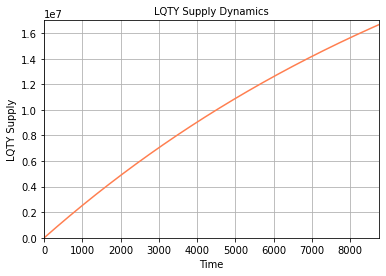

In [ ]:
x = np.linspace(0, period, period)
y = (100000000/3)*(1-0.5**(x/period))
plt.plot(x, y, color='coral')
plt.grid()
plt.xlim(0, period)
plt.ylim(0, 17000000)
plt.title('LQTY Supply Dynamics',fontsize=10)
plt.xlabel('Time')
plt.ylabel('LQTY Supply')
plt.show()

In [ ]:
5*1.0012**720

11.857017978846065

**LQTY Endogenous Price**

The staked LQTY pool earning consists of the issuance fee revenue and redemption fee revenue
> $R_t^q = R_t^i + R_t^r.$

From period 721 onwards, using the data in the last 720 periods (i.e. the last 30 days), we can calculate the annualized earning

> $$E_t=\frac{365}{30}\sum_{\tau=t-720}^{t-1}R_\tau^q.$$

For example, in period 721 (the first hour of the second month), we can calculate the annualized earning

> $$E_{721}=\frac{365}{30}\sum_{\tau=1}^{720}R_\tau^q.$$

In period 722 (the second hour of the second month), we can calculate the annualized earning

> $$E_{722}=\frac{365}{30}\sum_{\tau=2}^{721}R_\tau^q.$$

The annualized earning $E_t$ takes into account the last 720 periods' earning only and then annualize it to represent the whole year's revenue.
Only the latest 720 periods matter! The earlier ones become irrelevant over time.

The P/E ratio is defined as follows

> $$r_t=r^{PE}(1+\zeta_t^{PE}),$$

where $r^{PE}=100$ and $\zeta_t^{PE}\sim N(0, 0.1)$.

> $$r_t=\frac{LQTY Market Cap}{Annualized Earning}=\frac{MC_t}{E_t}$$

> $$MC_t=P_t^qQ^q.$$

Therefore, the LQTY price dynamics is determined
> $$P_t^q=\frac{r^{PE}(1+\zeta_t^{PE})}{Q^q}E_t.$$


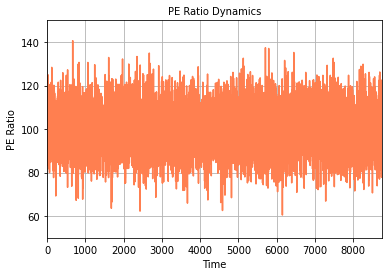

In [ ]:
PE = 100
PE_ratio = [PE]
for i in range(1, period):
  random.seed(2097+8*i)
  shock_PE = np.random.normal(0,0.1)
  PE = 100
  PE_ratio.append(PE*(1+shock_PE))

x = np.linspace(0, period, period)
y = PE_ratio
plt.plot(x, y, color='coral')
plt.grid()
plt.xlim(0, period)
plt.ylim(50, 150)
plt.title('PE Ratio Dynamics',fontsize=10)
plt.xlabel('Time')
plt.ylabel('PE Ratio')
plt.show()

LUSD market price $P_t^l$ is endogenously determined by the market clearing condition of the LUSD tokens as follows

> $S_t = D_t^s + D_t^l$,

where $D_t^s$ and $D_t^l$ represent the demand for LUSD tokens in the stability pool and liquidity pool, respectively.
$S_t$ represents the supply of LUSD tokens from the trove pool. In each period some new troves are opened (added to the pool) and some troves are closed (subtracted from the pool). 
The supply is the sum of the debts of all the troves in the trove pool,
regardless whether it is newly opened or adjusted.
Those liquidated and closed troves are removed from the trove pool. Therefore,
their debts are not counted.

Caveat: for the adjusted troves, count all the debts. Not only the changed parts!


**Simulation Program**

---
With all the parameters defined above, the price of LUSD in every period will be calculated by $S_t = D_t^s + D_t^l$, where $S_t$ is the total supply in the troves. 
> $P_t^l = P_{t-1}^l (\frac{S_t-D_t^s}{D_{t-1}^l (1+\zeta_t^l)})^{1/\delta}$

The simulation is done below.

In [ ]:
#Defining Initials
initials = {"Price_LUSD":[1.00], "n_open":[80], "n_close":[10], "n_liquidate": [0], "n_redempt":[0],
            "liquidity":[100000], "stability":[10000], "issuance_fee":[0], "redemption_fee":[0],
            "n_troves":[100], "supply_LUSD":[0],  "return_stability":[0], "redemption_pool":[0],
            "airdrop_gain":[0], "liquidation_gain":[0], 
            "price_LQTY":[0.1], "MC_LQTY":[186.3], "annualized_earning":[0]}
data = pd.DataFrame(initials)
troves= pd.DataFrame({"Ether_Price":[], "Ether_Quantity":[], "CR_initial":[], 
              "Supply":[], "Rational_inattention":[], "CR_current":[]})
result_open = open_troves(troves, 0, data['Price_LUSD'][0], data['n_open'][0])
troves = result_open[0]
issuance_LUSD_open = result_open[2]
data.loc[0,'issuance_fee'] = issuance_LUSD_open * initials["Price_LUSD"][0]
data.loc[0,'supply_LUSD'] = troves["Supply"].sum()
theta = 1
delta = -1

#Simulation Process
for index in range(1, 300):
#exogenous ether price input
  price_ether_current = price_ether[index]

#trove liquidation & return of stability pool
  result_liquidation = liquidate_troves(troves, index, data.loc[index-1,'Price_LUSD'], data.loc[index-1,'stability'])
  troves = result_liquidation[0]
  return_stability = result_liquidation[1]
  debt_liquidated = result_liquidation[2]
  ether_liquidated = result_liquidation[3]
  liquidation_gain = result_liquidation[4]
  airdrop_gain = result_liquidation[5]
  n_liquidate = result_liquidation[6]

#close troves
  result_close = close_troves(troves, index, data.loc[index-1,'Price_LUSD'], data.loc[index-1,'n_close'])
  troves = result_close[0]
  n_close = result_close[1]

#adjust troves
  result_adjustment = adjust_troves(troves, index)
  troves = result_adjustment[0]
  issuance_LUSD_adjust = result_adjustment[1]

#open troves
  result_open = open_troves(troves, index, data.loc[index-1,'Price_LUSD'], data.loc[index-1,'n_open'])
  troves = result_open[0]
  n_open = result_open[1]  
  issuance_LUSD_open = result_open[2]

#Stability Pool
  stability_pool = stability_update(data.loc[index-1,'stability'], return_stability, index)[0]

#Calculating Price, Liquidity Pool, and Redemption
  result_price = price_stabilizer(troves, index, data, stability_pool)
  price_LUSD_current = result_price[0]
  liquidity_pool = result_price[1]
  troves = result_price[2]
  issuance_LUSD_stabilizer = result_price[3]
  redemption_fee = result_price[4]
  n_redempt = result_price[5]
  redemption_pool = result_price[6]

#LQTY Market
  result_LQTY = LQTY_market(index, data)
  price_LQTY_current = result_LQTY[0]
  annualized_earning = result_LQTY[1]
  MC_LQTY_current = result_LQTY[2]

#Summary
  issuance_fee = price_LUSD_current * (issuance_LUSD_adjust + issuance_LUSD_open + issuance_LUSD_stabilizer)
  n_troves = troves.shape[0]
  supply_LUSD = troves['Supply'].sum()

  new_row = {"Price_LUSD":float(price_LUSD_current), "n_open":float(n_open), "n_close":float(n_close), 
             "n_liquidate":float(n_liquidate), "n_redempt": float(n_redempt), 
             "liquidity":float(liquidity_pool), "stability":float(stability_pool), 
             "issuance_fee":float(issuance_fee), "redemption_fee":float(redemption_fee),
             "n_troves":float(n_troves), "supply_LUSD":float(supply_LUSD), 
             "return_stability":float(return_stability), "redemption_pool":float(redemption_pool), 
             "airdrop_gain":float(airdrop_gain), "liquidation_gain":float(liquidation_gain),
             "price_LQTY":float(price_LQTY_current), "MC_LQTY":float(MC_LQTY_current), 
             "annualized_earning":float(annualized_earning)}
  data = data.append(new_row, ignore_index=True)
  if price_LUSD_current < 0:
    break